In [33]:
import torch

In [34]:
### Select device (GPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print('Selected device:', device)

Selected device: cuda


In [35]:
import string
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

import unicodedata
# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

import os
import glob
from io import open
for filename in glob.glob('../data-sets/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    lines = [unicodeToAscii(line) for line in lines]
    category_lines[category] = lines
    all_categories.append(category)

n_categories = len(category_lines.keys())

print('Amount of categories:', n_categories)
print('Some Dutch examples:', category_lines['Dutch'][:5])

Amount of categories: 18
Some Dutch examples: ['Aalsburg', 'Aalst', 'Aarle', 'Achteren', 'Achthoven']


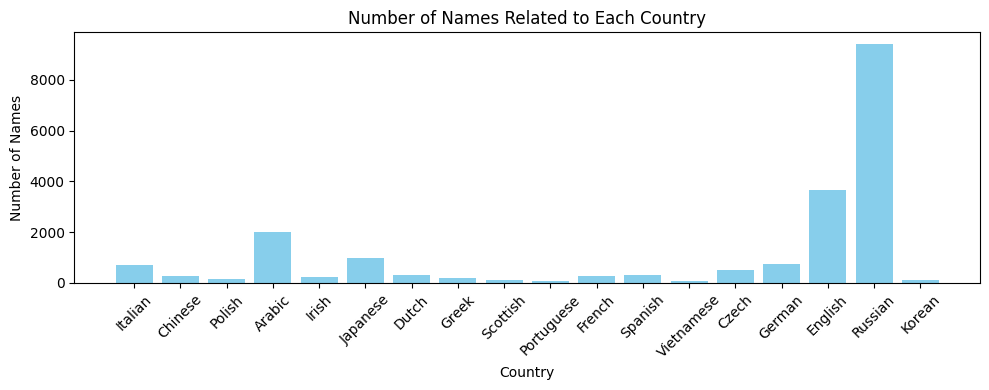

In [36]:
import matplotlib.pyplot as plt

# Get the number of names for each country
num_names = [len(names) for names in category_lines.values()]

# Create the bar chart
plt.figure(figsize=(10, 4))
plt.bar(all_categories, num_names, color='skyblue')
plt.xlabel('Country')
plt.ylabel('Number of Names')
plt.title('Number of Names Related to Each Country')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [37]:
max_length = 0

for key, values in category_lines.items():
    for name in values:
        max_length = max(max_length, len(name))

print('Maximum length:', max_length)

Maximum length: 19


In [38]:
char_to_num = {char: num for num, char in enumerate(all_letters)}
num_to_char = {num: char for char, num in char_to_num.items()}

cat_to_num = {cat: num for num, cat in enumerate(all_categories)}
num_to_cat = {num: cat for cat, num in cat_to_num.items()}

In [39]:
import torch
import random
import torch.nn.functional as F

def encode_line(line):
    enc = torch.tensor([char_to_num[c] for c in line])
    one_hot_enc = F.one_hot(enc, num_classes=n_letters)
    
    padding_length = max(0, max_length - one_hot_enc.shape[0])
    pad_enc = F.pad(one_hot_enc, (0, 0, 0, padding_length), mode='constant', value=0)

    return pad_enc.float()


def encode_category(category):
    enc = torch.tensor(cat_to_num[category])
    one_hot_enc = F.one_hot(enc, num_classes=n_categories)

    return one_hot_enc.float()


def build_dataset(key, lines):
    X, Y = [], []

    for line in lines:
        X.append(encode_line(line))
        Y.append(encode_category(key))
    
    X = torch.stack(X)
    Y = torch.stack(Y)

    return X, Y


Xtr, Ytr = [], []
Xte, Yte = [], []

for key, lines in category_lines.items():
    lines = random.sample(lines, len(lines))
    split = int(0.9 * len(lines))

    Xtr_part, Ytr_part = build_dataset(key, lines[:split])
    Xte_part, Yte_part = build_dataset(key, lines[split:])

    Xtr.append(Xtr_part)
    Ytr.append(Ytr_part)
    Xte.append(Xte_part)
    Yte.append(Yte_part)

Xtr = torch.cat(Xtr, dim=0).to(device)
Ytr = torch.cat(Ytr, dim=0).to(device)
Xte = torch.cat(Xte, dim=0).to(device)
Yte = torch.cat(Yte, dim=0).to(device)

ix = random.randint(0, Xtr.shape[0] - 1)
print('Shape of training data:', Xtr.shape, '=>', Ytr.shape)
print(
    'Random train example:',
    ''.join([num_to_char[torch.argmax(word).item()] for word in Xtr[ix] if torch.any(word != 0)]),
    '=>',
    num_to_cat[torch.argmax(Ytr[ix]).item()]
)
ix = random.randint(0, Xte.shape[0] - 1)
print(
    'Random test example:',
    ''.join([num_to_char[torch.argmax(word).item()] for word in Xte[ix] if torch.any(word != 0)]),
    '=>',
    num_to_cat[torch.argmax(Yte[ix]).item()]
)

Shape of training data: torch.Size([18060, 19, 57]) => torch.Size([18060, 18])
Random train example: Nartey => English
Random test example: Mombelli => Russian


In [40]:
import torch.nn as nn

n_hidden = 50

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

model = RNN(n_letters, n_hidden, n_categories).to(device)

print('Total parameters:', sum(p.numel() for p in model.parameters()))

Total parameters: 6368


In [41]:
lr = 0.0003

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [42]:
import torch.nn.functional as F

epochs = 100000
batch_size = 512
eval_batch_size = 10000

epoch_count = []
train_loss_values = []
test_loss_values = []
ud = []

### Train loop ###
from tqdm import trange
for epoch in trange(epochs):
    model.train()
    
    # Sample mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), device=device)
    Xb, Yb = Xtr[ix], Ytr[ix]

    output = model(Xb)           # Do the forward pass
    loss = criterion(output, Yb) # Calculate the loss
    optimizer.zero_grad()        # Reset parameters
    loss.backward()              # Backpropagation
    optimizer.step()             # Update parameters
    
    # Report progression every so often
    if ((epoch + 1) % (epochs / 50) == 0):
        
        # Sample larger train-batch
        ix = torch.randint(0, Xtr.shape[0], (eval_batch_size,), device=device)
        Xb, Yb = Xtr[ix], Ytr[ix]

        model.eval()
        with torch.inference_mode():
            outputs = model(Xb)
            loss = F.cross_entropy(outputs, Yb)

            ud.append([((lr * p.grad).std() / p.data.std()).log10().item() for p in model.parameters()])

        # Sample larger test-batch
        ix = torch.randint(0, Xte.shape[0], (eval_batch_size,), device=device)
        Xb, Yb = Xte[ix], Yte[ix]

        model.eval()
        with torch.inference_mode():
            outputs = model(Xb)
            test_loss = F.cross_entropy(outputs, Yb)
        
        epoch_count.append(epoch)
        train_loss_values.append(loss.detach().item())
        test_loss_values.append(test_loss.detach().item())

# Print final results
print('Final training loss:', round(loss.detach().item(), 3))
print('Final test loss:', round(test_loss.detach().item(), 3))

100%|██████████| 100000/100000 [01:35<00:00, 1044.71it/s]

Final training loss: 0.498
Final test loss: 1.033


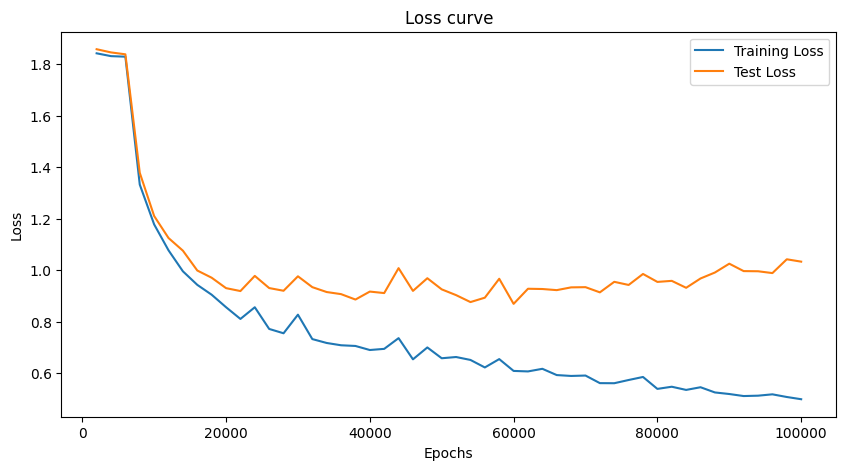

In [43]:
import matplotlib.pyplot as plt

### Visualize loss progression ###
plt.figure(figsize=(10, 5))
plt.plot(epoch_count, train_loss_values, label="Training Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.title("Loss curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

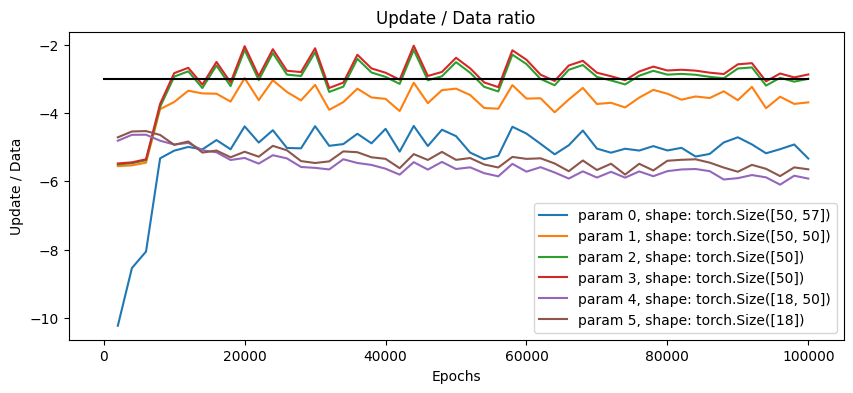

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
legends = []
for i,p in enumerate(model.parameters()):
  # if p.ndim == 2:
  plt.plot(epoch_count, [ud[j][i] for j in range(len(ud))])
  legends.append('param ' + str(i) + ', shape: ' + str(p.shape))
plt.plot([0, max(epoch_count)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.title("Update / Data ratio")
plt.xlabel("Epochs")
plt.ylabel("Update / Data")
plt.legend(legends)

plt.show()

In [45]:
# Helpers
def evaluate(line):
    model.eval()
    with torch.inference_mode():
        outputs = model(line.to(device))
    
    return outputs.detach()

/tmp/ipykernel_1560311/841107671.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_1560311/841107671.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


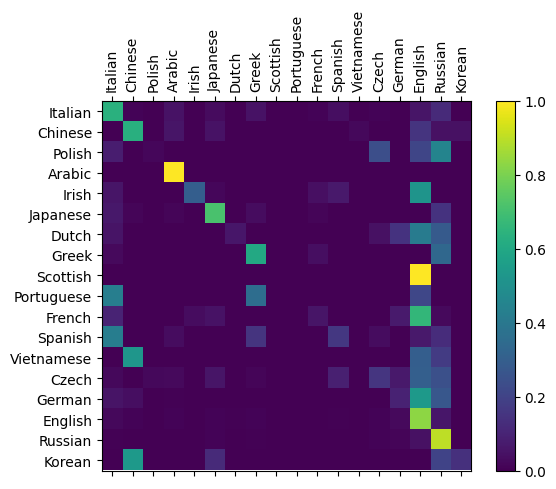

In [46]:
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    ix = torch.randint(0, Xte.shape[0], (1,))
    Xb, Yb = Xte[ix], Yte[ix]
    output = evaluate(Xb)
    
    ix_actual_category = torch.argmax(Yb.squeeze(0)).item()
    ix_guessed_catgeory = torch.argmax(output.squeeze(0)).item()

    confusion[ix_actual_category][ix_guessed_catgeory] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [47]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(encode_line(input_line).unsqueeze(0))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            cat_ix = topi[0][i].item()
            print('(%.2f) %s' % (value, num_to_cat[cat_ix]))
            predictions.append([value, num_to_cat[cat_ix]])

predict('Dovesky')
predict('Jackson')
predict('Apeldoorn')
predict('Anniek')
predict('Giovinacci')
predict('Marijn')


> Dovesky
(12.48) Russian
(6.86) Czech
(5.21) German

> Jackson
(5.46) English
(2.89) Russian
(2.70) German

> Apeldoorn
(5.98) Dutch
(5.43) German
(4.06) English

> Anniek
(5.69) Czech
(5.27) Polish
(3.86) Russian

> Giovinacci
(9.83) Italian
(6.66) Spanish
(4.89) Portuguese

> Marijn
(5.31) English
(3.92) German
(3.21) Dutch
